# Анализ групп и AB тест для приложения онлайн-знакомств

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Посмотрим на данные в датафрейме:

In [7]:
dating_data = pd.read_csv('~/dating_data.csv')
dating_data.head(20)

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1
5,227,162,0,0
6,435,16,1,0
7,602,327,1,0
8,223,295,0,0
9,133,463,1,1


In [8]:
dating_data.describe()

,user_id_1,user_id_2,group,is_match
count,14514.000000,14514.000000,14514.000000,14514.000000
mean,500.220132,501.843737,0.669836,0.333678
std,288.703825,287.250879,0.470288,0.471542
min,1.000000,1.000000,0.000000,0.000000
25%,253.000000,255.000000,0.000000,0.000000
50%,504.000000,500.000000,1.000000,0.000000
75%,751.000000,752.750000,1.000000,1.000000
max,1000.000000,1000.000000,1.000000,1.000000


In [9]:
dating_data.shape

(14514, 4)

In [10]:
dating_data.dtypes

user_id_1    int64
user_id_2    int64
group        int64
is_match     int64
dtype: object

Всего позиций в каждой колонке пользователей - 14514:

In [11]:
dating_data.user_id_2.count() 

14514

А уникальных юзеров по 1000 в каждой из колонок по 1000 

In [12]:
#dating_data.user_id_2.nunique() 
dating_data.user_id_2.nunique() 

1000

Каждый пользователь встречается разное количество раз в каждой колонке. <br>
Это говорит о том, что в строках мы видим различные комбинации 1000 юзеров из первой колонки и 1000 юзеров из второй колонки. 

In [13]:
#dating_data.user_id_1.value_counts()
dating_data.user_id_2.value_counts()

716    34
238    34
787    33
981    32
314    31
       ..
650     4
335     4
46      4
27      3
883     3
Name: user_id_2, Length: 1000, dtype: int64

#### Посмотрим на <Q>абсолютные данные</Q> по тестовой и контрольной группам. <br> На то, сколько всего у нас получилось удачных пар  

Тестовая группа:

In [14]:
dating_data.query('group == 1').is_match.value_counts()

0    5813
1    3909
Name: is_match, dtype: int64

Контрольная группа:

In [15]:
dating_data.query('group == 0').is_match.value_counts()

0    3858
1     934
Name: is_match, dtype: int64

1. Тестовая группа больше контрольной, что, конечно, странно. 
2. На первый взгляд в тестовой группе доля is_match, то есть образовавшихся взаимных симпатий, больше.

#### Выбираем метрики

1. Доля мэтчей. Очевидно, что качество сервиса можно измерить в общей доле is_match для каждой группы - чем она выше, тем лучше. <br> Большая доля понравившихся друг другу людей среди всех исследуемых скажет о том, что цель приложения достигается.
<hr>
2. Успешность выбора. Вторая метрика - это доля мэтчей среди всех контактов каждого пользователя. Высокая доля укажет на то, что пользователям показываются релевантные по интересам пары, поэтому они с удовольствием лайкают друг друга, часто образуя пары.

### Метрика 1. Доля мэтчей

#### 1. Визуализируем данные, чтобы посмотреть на долю is_match. 

- В тестовой группе она явно больше. Определим статсзначимость.

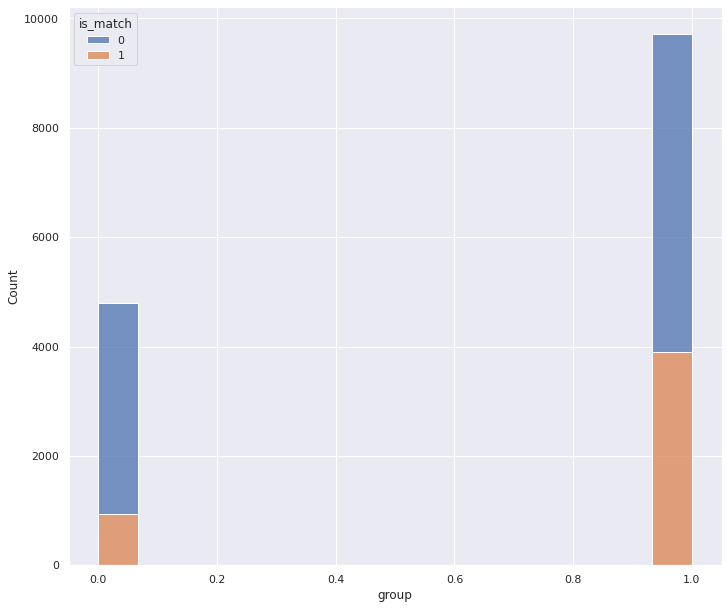

In [16]:
sns.set(rc={'figure.figsize':(11.7,10.27)})
ax = sns.histplot(dating_data, x='group', hue = 'is_match', multiple='stack')

Формируем гипотезы: <br>
- $H_0$: изменение не повлияло на долю понравившихся друг другу пользователей приложения
- $H_1$: изменение повлияло

#### 2. Выбор и проведение теста. 

- Переменные у нас качественные, независимые и их всего две, поэтому проводим тест с помощью Хи-квадрата Пирсона:

In [17]:
from scipy.stats import chi2_contingency

In [18]:
stat, p1, dof, expected = chi2_contingency(pd.crosstab(dating_data.group, dating_data.is_match))
stat, p1, dof 

(618.6889141576198, 1.4418299163662586e-136, 1)

- Определяем доверительный интервал и значение альфа, чтобы сравнить его с получившимся p-value.

In [19]:
prob = 0.95
alpha = 1.0 - prob
if p1 <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


- Даже если мы увеличим доверительный интервал, уменьшив значение альфа и повысив чувствительность теста, то нулевая гипотеза всё равно будет отклонена, так как значени p-value очень маленькое, значит различия в группах существенные.
##### Мы можем сказать, что изменение, произведённое в приложении, статистически значимо повлияло на долю мэтчей. Их стало больше.

### Метрика 2. Успешность

#### 1. Предварительные действия.
Нам надо провести дополнительные манипуляции, чтобы проверить некоторые догадки и предобработать данные для теста.

- Ранее мы увидели, что уникальных юзеров в каждой колонке по 1000. <br> Теперь построим уникальные значения юзеров по порядку. Мы видим, что это числа от 1 до 1000 без повторов и других чисел:

In [20]:
pd.DataFrame(dating_data.user_id_1.sort_values().unique())

,0
0,1
1,2
2,3
3,4
4,5
...,...
995,996
996,997
997,998
998,999


- Во второй колонке ровно те же числа. Похоже, что это одни и те же юзеры:

In [21]:
pd.DataFrame(dating_data.user_id_2.sort_values().unique())

,0
0,1
1,2
2,3
3,4
4,5
...,...
995,996
996,997
997,998
998,999


- Для AB теста пользователи были разделены примерно на равные группы -  499  и 501 человек.
Одинаковое количество (499 и 499, 501 и 501) сохраняется в обоих столбцах с юзерами для каждой тестируемой группы. То есть проверяются связи 1000 человек
между собой. Пересечений в связях контрольной и тестовой групп нет: 

In [22]:
#pd.DataFrame(dating_data.query('group == 1').user_id_1.sort_values().unique())
#pd.DataFrame(dating_data.query('group == 0').user_id_1.sort_values().unique())
#pd.DataFrame(dating_data.query('group == 1').user_id_2.sort_values().unique())
pd.DataFrame(dating_data.query('group == 0').user_id_2.sort_values().unique())

,0
0,4
1,10
2,12
3,14
4,15
...,...
496,994
497,995
498,996
499,997


- Ещё одно подтверждение, что в контрольной группе и тестовой нет пересечений:

In [23]:
#one = dating_data.query('group == 1').user_id_2.sort_values().unique()
#zero = dating_data.query('group == 0').user_id_2.sort_values().unique()
one = dating_data.query('group == 1').user_id_1.sort_values().unique()
zero = dating_data.query('group == 0').user_id_1.sort_values().unique()

for i in one:
    if i == i in zero:
        print(i)
    else:
        print('nothing')  

nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing
nothing


#### 2. Расчитываем метрику.
Теперь мы можем посмотреть поведение всех уникальных пользователей из 1 колонки и посчитать, сколько они замэтчили людей из 2 колонки. Посчитаем это для контрольной и тестовой группы.

 - Сначала возьмём контрольную группу.

In [24]:
Control = dating_data.query('group == 0').groupby('user_id_1', as_index = False) \
          .agg({'is_match' : 'sum'}).sort_values(by = 'user_id_1')

#Добавляем колонку успешности: мэтчи делим на попытки мэтчей (все просмотры анкет)
Control['success'] = Control.is_match / dating_data.query('group == 0').groupby('user_id_1', as_index = False) \
          .agg({'is_match' : 'count'}).sort_values(by = 'user_id_1').is_match

- В итоге мы получили колонку <q>успешности</q> каждого пользователя в поиске пары, разделив его успешные мэтчи на попытки (колонка <q>success</q>).

In [25]:
Control

,user_id_1,is_match,success
0,4,2,0.222222
1,10,3,0.500000
2,12,1,0.083333
3,14,0,0.000000
4,15,3,0.150000
...,...,...,...
496,994,2,0.222222
497,995,2,0.250000
498,996,1,0.125000
499,997,1,0.083333


#### - Визуализируем
На вид не совсем нормальное распределение, надо будет проверить с помощью теста Шапиро-Уилка.

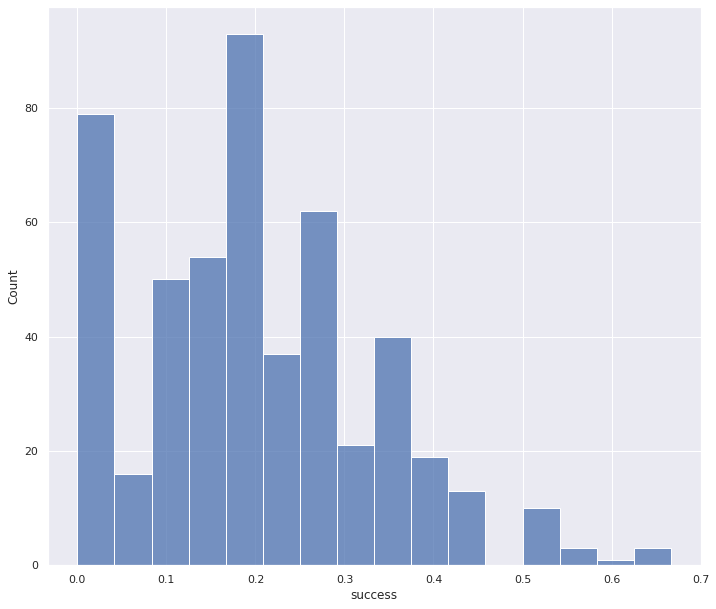

In [26]:
sns.histplot(Control, x='success')

In [27]:
from scipy.stats import shapiro

- Тест Шапиро-Уилка показывает, что распределение действительно не нормальное (значение p-value очень мало):

In [28]:
shapiro(Control.success)

ShapiroResult(statistic=0.9572262763977051, pvalue=7.058642559343298e-11)

- Проводим расчёт и создаём колонку <q>успешности</q> для тестовой группы.

In [29]:
Test = dating_data.query('group == 1').groupby('user_id_1', as_index = False) \
          .agg({'is_match' : 'sum'}).sort_values(by = 'user_id_1')

Test['success'] = Test.is_match / dating_data.query('group == 1').groupby('user_id_1', as_index = False) \
          .agg({'is_match' : 'count'}).sort_values(by = 'user_id_1').is_match

#### - Визуализируем
Выглядит как нормальное распределение.

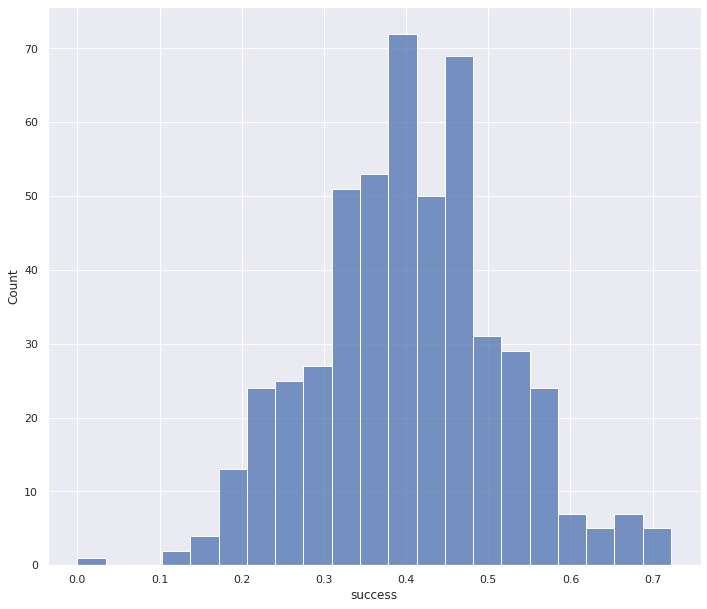

In [30]:
sns.histplot(Test, x='success')

- Проверка это подтверждает.

In [31]:
shapiro(Test.success)

ShapiroResult(statistic=0.9960588216781616, pvalue=0.2503166198730469)

#### 3. Выбор и проведение теста

- Данные у нас количественные, распределения двух видов - нормальное и не нормальное, группы независимые и всего их две.
- Выбираем критерий Манна-Уитни

In [32]:
from scipy.stats import mannwhitneyu

In [33]:
stat, p2 = mannwhitneyu(x = Test.success, y = Control.success)
stat, p2

(220237.0, 1.0739285895805636e-96)

- Посмотрим на медианы распределений. У тестовой группы она в два раза больше.

In [34]:
Control.success.median()

0.18181818181818182

In [35]:
Test.success.median()

0.4

- Определяем доверительный интервал и значение альфа, чтобы сравнить его с получившимся p-value.

In [36]:
prob = 0.95
alpha = 1.0 - prob
if p2 <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


##### Между тестовой и контрольной группой есть статистически значимые отличия в метрике <q>успешности</q> в получении мэтчей для пользователей. У пользователей из тестовой группы выше доля полученных взаимных лайков.

### ИТОГ
##### В тестовой группе наблюдаются улучшения в работе сервиса по двум показателям - доле мэтчей и <q>успешности</q> пользователей. Различия в показателях тестовой и контрольной групп являются статистически значимыми.